# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib

data_type = 'float32'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import pycell2location

from matplotlib import rcParams
import seaborn as sns
import itertools
import scipy

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

## Load input data 

First we load sample annotations.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata = adata[adata.obs['sample'] == 'exper0',:]
adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')
design = adata.uns['design']['cell_types2zones']
design, adata_snrna_raw, adata

(                tissue_zone_0  tissue_zone_1  tissue_zone_2  tissue_zone_3  \
 Inh_3                0.000000       0.000000       0.934032       0.000000   
 Ext_Pir              0.000000       0.000000       0.000000       0.000000   
 Oligo_2              0.000000       0.661809       0.000000       0.000000   
 Astro_HYPO           0.000000       0.000000       0.000000       0.000000   
 Ext_L25              0.000000       0.000000       0.000000       0.000000   
 Astro_THAL_lat       0.000000       0.000000       0.000000       0.000000   
 Ext_L5_1             0.000000       0.000000       0.000000       0.000000   
 Ext_L23              0.000000       0.000000       0.000000       0.000000   
 Micro                0.000000       0.000000       0.000000       0.000000   
 Ext_Thal_1           0.000000       0.000000       0.000000       0.000000   
 Ext_Hpc_CA1          0.000000       0.000000       0.000000       0.000000   
 Inh_Meis2_3          0.000000       0.000000       

Add counts matrix as `adata.raw` 

In [3]:
# Select genes expressed by at least 2% of cells in each cluster.
adata_snrna_raw_bin = adata_snrna_raw.copy()
adata_snrna_raw_bin.X = adata_snrna_raw_bin.X > 0
adata_snrna_raw_bin.raw = adata_snrna_raw_bin
prop_expressed = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw_bin, 'annotation_1')
prop_expressed = prop_expressed.loc[adata_snrna_raw.var_names,:]
adata_snrna_raw = adata_snrna_raw[:, prop_expressed.max(1) > 0.02]

In [4]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

#### Select genes using expression in non-zero cells

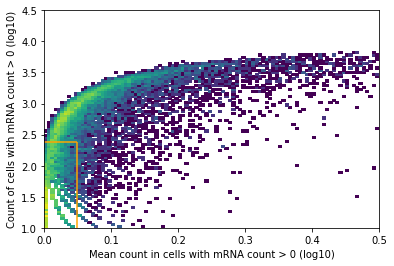

In [5]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [6]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8111, 12293)

In [7]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [8]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8111 × 12293
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

#### Plot numbers of cells per spot

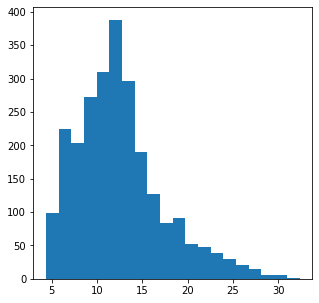

In [9]:
from re import sub
cell_count = adata_vis.obs.loc[:, ['cell_abundances_' in i for i in adata_vis.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
umi_count = adata_vis.obs.loc[:, ['UMI_count_' in i for i in adata_vis.obs.columns]]
umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist(cell_count.sum(1), bins=20);

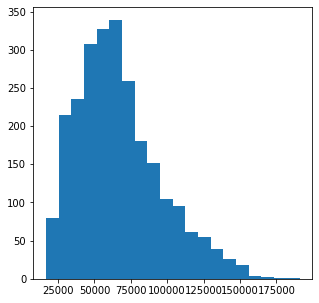

In [10]:
plt.hist(umi_count.sum(1), bins=20);

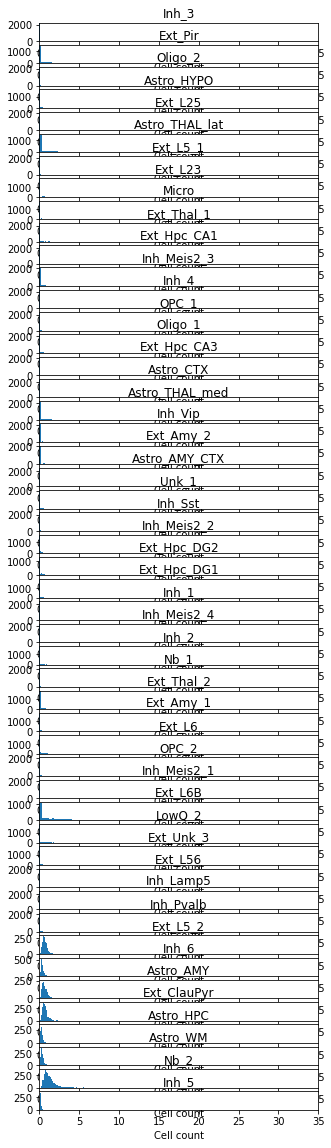

In [11]:
rcParams['figure.figsize'] = 5, 20
for i, c in enumerate(cell_count.columns):
    plt.subplot(cell_count.shape[1], 1, i+1)
    plt.hist(cell_count[c], bins = 35);
    plt.xlabel('Cell count');
    plt.xlim(0, 35);
    plt.title(str(c));
plt.tight_layout()

#!cd /nfs/team283/vk7/software/ && git clone https://github.com/YosefLab/scvi-tools.git
!cd /nfs/team283/vk7/software/scvi-tools/ && git pull
!cd /nfs/team283/vk7/software/scvi-tools/ && git checkout romain/spatial
!cd /nfs/team283/vk7/software/scvi-tools/ && python setup.py install

#!pip install rich
!pip install git+https://github.com/YosefLab/scvi-tools.git@ea693d8425dc6b4a077165a8ddc33443ed973670 --upgrade
#!pip install scvi-tools --upgrade
#!pip install scikit-misc --force

## Perform scVI signature estimation

In [12]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import scStereoscope, stStereoscope
import scvi

rcParams['figure.figsize'] = 5, 5

In [13]:
adata_snrna_raw.layers["counts"] = adata_snrna_raw.X.copy()
sc.pp.normalize_total(adata_snrna_raw, target_sum = 10e4)
sc.pp.log1p(adata_snrna_raw)
adata_snrna_raw.raw = adata_snrna_raw

In [14]:
scvi.data.setup_anndata(adata_snrna_raw, layer = "counts", labels_key = "annotation_1")

adata_snrna_raw.obs["indices"] = np.arange(adata_snrna_raw.n_obs)
register_tensor_from_anndata(adata_snrna_raw, "ind_x", "obs", "indices")

model = scStereoscope(adata_snrna_raw)
model.train(lr = 0.01, n_epochs = 1500, frequency = 1, batch_size=1024)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["annotation_1"]                                         
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8111 cells, 12293 genes, 1        
         batches, 49 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 1500 epochs                                                            
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  1473 s. / 1500 epochs                                               


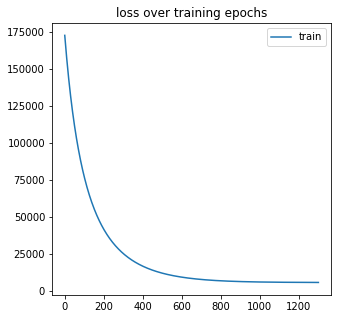

In [15]:
plt.plot(model.history["elbo_train_set"][200:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [16]:
params = model.get_params()
params[0].shape
model.save(f"{results_folder}scvi_stereoscope/scmodel_1k.pkl", overwrite = True)

- Filter genes to be the same as the scRNA-Seq data

In [22]:
intersect = np.intersect1d(adata_snrna_raw.var_names, adata.var_names)
intersect_ind = adata_snrna_raw.var_names.isin(intersect)
intersect = adata_snrna_raw.var_names[intersect_ind]

adata = adata[:, intersect].copy()
adata_snrna_raw = adata_snrna_raw[:, intersect].copy()

params = [params[0][intersect_ind, :], params[1][intersect_ind]]
len(adata_snrna_raw.var_names) == params[0].shape[0]

True

In [33]:
adata.layers["counts"] = adata.X.copy()
scvi.data.setup_anndata(adata, layer = "counts")

adata.obs["indices"] = np.arange(adata.n_obs)
register_tensor_from_anndata(adata, "ind_x", "obs", "indices")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2500 cells, 12054 genes, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [34]:
spatial_model = stStereoscope(adata, params)
spatial_model.train(lr = 0.01, n_epochs = 30000, train_size = 1, frequency = 1, batch_size=1250)

INFO     Training for 30000 epochs                                                           
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  9420 s. / 30000 epochs                                              


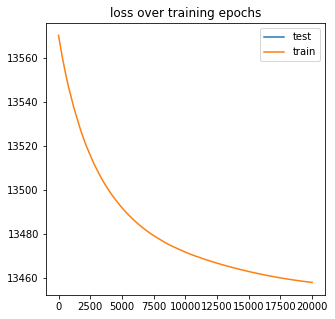

In [35]:
plt.plot(spatial_model.history["elbo_test_set"][10000:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][10000:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [36]:
import pandas as pd
adata.obsm["decomposition"] = pd.DataFrame(data = spatial_model.get_proportions(), index = adata.obs.index, 
                                           columns = adata_snrna_raw.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"])


In [37]:
for ct in adata.obsm["decomposition"].columns:
    adata.obs[ct] = adata.obsm["decomposition"][ct]

In [38]:
adata.obsm["decomposition"].sum(1)

exper0_location_0       1.0
exper0_location_1       1.0
exper0_location_2       1.0
exper0_location_3       1.0
exper0_location_4       1.0
                       ... 
exper0_location_2495    1.0
exper0_location_2496    1.0
exper0_location_2497    1.0
exper0_location_2498    1.0
exper0_location_2499    1.0
Length: 2500, dtype: float32

In [39]:
spatial_model

stDeconv Model with params: 
gene_likelihood: nb
Training status: Trained

In [40]:
adata.write(f"{results_folder}scvi_stereoscope/sp_n_epochs30k.h5ad")